In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import math

from sklearn.cluster import KMeans
from IPython.display import display #So that I can view all 8 columns in output
from sklearn import preprocessing
from sklearn.metrics import silhouette_score


In [3]:
#importing file in google colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
#Reading file from GDrive
df = pd.read_excel("/content/gdrive/My Drive/Projects/Online_Retail.xlsx")

pd.set_option('display.max_columns', None)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [95]:
# I) DATA CLEANING

# 1) Details of df
#  a) Checking types of columns
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [25]:
# b) Check for missing values
#df['InvoiceNo'].isnull().sum()
#df['StockCode'].isnull().sum()
#df['Description'].isnull().sum()
#df['Quantity'].isnull().sum()
#df['InvoiceDate'].isnull().sum()
#df['UnitPrice'].isnull().sum()
#df['CustomerID'].isnull().sum()
df['Country'].isnull().sum()

#We can see that Description, CustomerID and Country have null values (We later remove columns where CustomerID is null)

0

In [96]:
# c) checking summary of the df
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [97]:
# 2) As we can see above Quantity and UnitPrice have negative values which is not ideal. So we look into those values.
#  a) Checking for records where UnitPrice is negative

print(df[df['UnitPrice'] < 0])

       InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom  


In [5]:
#   3) a)Removing records where UnitPrice is negative; Quantity can be negative as it means that the items are returned
df = df[~(df.UnitPrice < 0)]

# b) removing records where CustID is null
df = df[~(df.CustomerID.isnull())]

In [6]:
# c) Verifying that they are gone
df['CustomerID'].isnull().sum()

df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [48]:
df['StockCode'].nunique()

3665

In [7]:
# II) VISUALIZATION OF DATA TO GET INSIGHTS

df.InvoiceDate = pd.to_datetime(df.InvoiceDate)  #Converting to standard date time format
df['Amount'] = df.Quantity*df.UnitPrice
df.CustomerID = df.CustomerID.astype('Int64') #Converting float to int

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


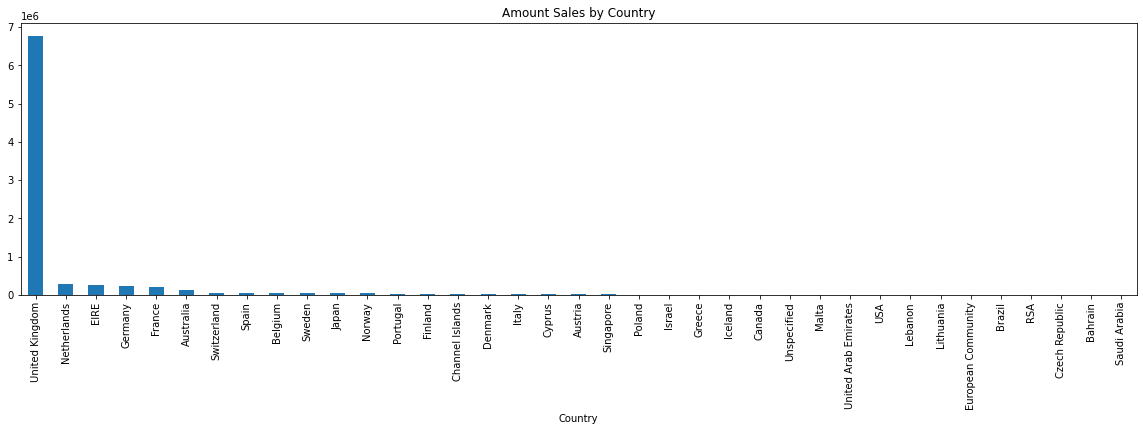

In [101]:
# 1) Sales by Country - Bar Graph
fig = plt.figure(figsize=(20, 5))
diag1 = df.groupby(["Country"]).Amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')

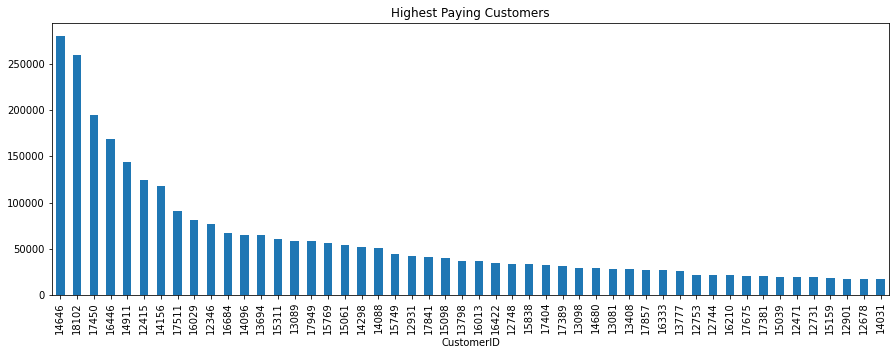

In [104]:
# Maximum Contribution by Customer (Amount) - Top 50

fig = plt.figure(figsize=(15,5))
df1 = df[(df.Quantity > 0)]
diag2 = df1.groupby(['CustomerID']).Amount.sum().sort_values(ascending=False)[:50].plot(kind='bar', title='Highest Paying Customers')

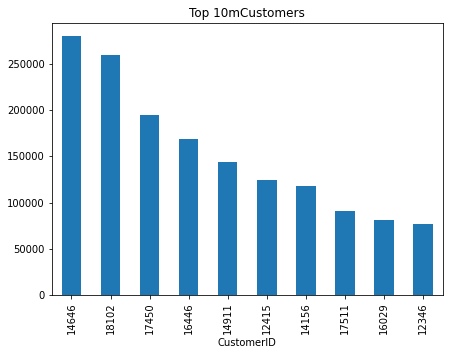

In [105]:
# Top 10 Customers
fig = plt.figure(figsize=(7,5))
diag2 = df1.groupby(['CustomerID']).Amount.sum().sort_values(ascending=False)[:10].plot(kind='bar', title='Top 10mCustomers')

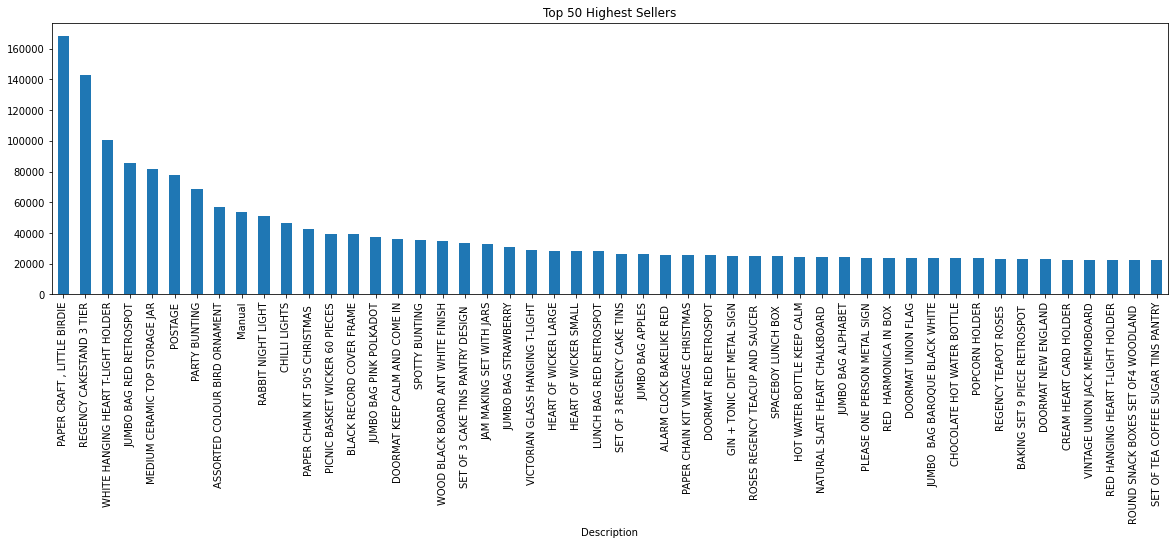

In [107]:
# Top 20 Products according to Sales

fig = plt.figure(figsize=(20,5))
diag3 = df1.groupby(['Description']).Amount.sum().sort_values(ascending=False)[:50].plot(kind='bar', title='Top 50 Highest Sellers')

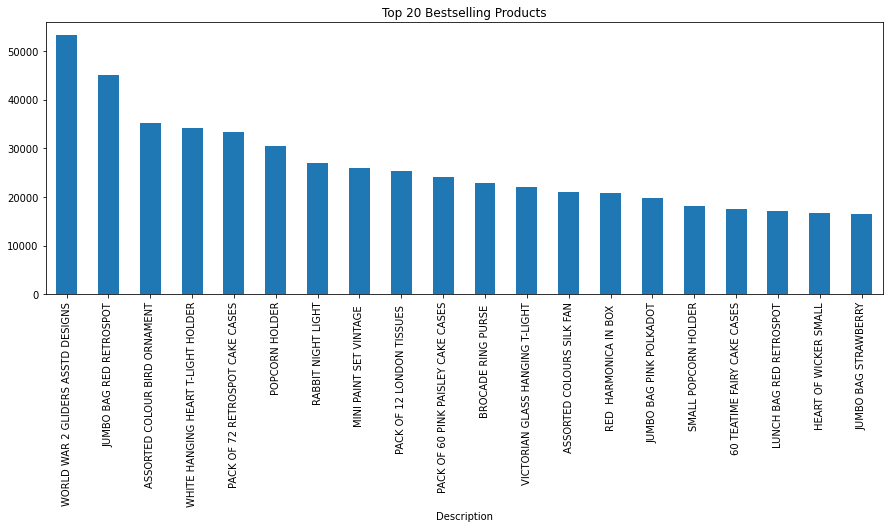

In [112]:
#Top 20 Most Sold Products
fig = plt.figure(figsize=(15,5))
diag4 = df.groupby(['Description']).Quantity.sum().sort_values(ascending=False)[:20].plot(kind='bar', title='Top 20 Bestselling Products')

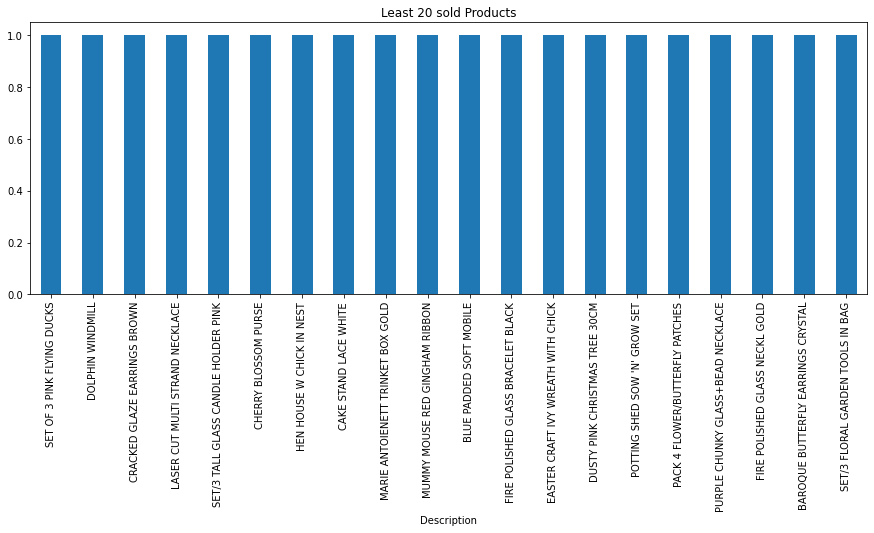

In [9]:
# Least sold 20 Products
fig = plt.figure(figsize=(15,5))
df1 = df[(df.Quantity > 0)]
diag4 = df1.groupby(['Description']).Quantity.sum().sort_values(ascending=True)[:20].plot(kind='bar', title='Least 20 sold Products')

In [115]:
# III) Deciding the optimal number of clusters

# Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, 
#based model of customer value for finding our customer segments.

# Recency: The value of how recently a customer purchased at the establishment
# Frequency: How frequent the customer’s transactions are at the establishment
# Monetary value: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

# Recency - To calculate recency we will i) take a reference date (Last transaction date + One day), 
#and ii) calculate the number of days before the reference date when a customer last made a purchase.

df = df[(df.Quantity > 0)]

refrence_date = df.InvoiceDate.max() + datetime.timedelta(days = 1) # i)
df['recency'] = (refrence_date - df.InvoiceDate).astype('timedelta64[D]') # ii)  recency = days since last purchase
customer_segment_df =  df[['CustomerID', 'recency']].groupby("CustomerID").min().reset_index() # reset_index changes the index from CustID to 0,1,..
# groupby minimum means minimum of the recency is displayed in the column; we'll need min because latest transaction is to be considered
customer_segment_df.head()

,CustomerID,recency
0,12346,326.0
1,12347,2.0
2,12348,75.0
3,12349,19.0
4,12350,310.0


In [116]:
# Frequency - How frequently (no of times) the customer has bought from the shop
df3 = df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index() # grouping all items that come in a single invoice number
customer_freq = df3.groupby(["CustomerID"]).count().reset_index() #Grouping all the invoices that belong to a single customer
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_segment_df = customer_segment_df.merge(customer_freq)
customer_segment_df.head()

,CustomerID,recency,frequency
0,12346,326.0,1
1,12347,2.0,7
2,12348,75.0,4
3,12349,19.0,1
4,12350,310.0,1


In [117]:
# Monetary value - All the total money spent by the customer in the shop
customer_monetary_val = df[['CustomerID', 'Amount']].groupby("CustomerID").sum().reset_index()
customer_segment_df = customer_segment_df.merge(customer_monetary_val)

customer_segment_df.head()

,CustomerID,recency,frequency,Amount
0,12346,326.0,1,77183.60
1,12347,2.0,7,4310.00
2,12348,75.0,4,1797.24
3,12349,19.0,1,1757.55
4,12350,310.0,1,334.40


In [118]:
customer_segment_df = customer_segment_df[customer_segment_df.Amount >0]
customer_segment_df.describe()

,CustomerID,recency,frequency,Amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272706,2054.266460
std,1721.808492,100.014169,7.706221,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,210.000000,280206.020000


In [119]:
# IV) Data Preprocessing  - Standardization and Transformation

# 1) Standardization - One of the requirements for proper functioning of the algorithm is the mean centering of the variable values. 
# Mean centering of a variable value means that we will replace the actual value of the variable with a standardized value, so that the variable has a mean of 0 and variance of 1. 
# This ensures that all the variables are in the same range and the difference in ranges of values doesn't cause the algorithm to not perform well.

# 2) Transformation - Another problem that you can investigate about is the huge range of values each variable can take. 
# To take care of this problem, we will transform all the variables on the log scale. 
# This transformation, along with the standardization, will ensure that the input to our algorithm is a homogenous set of scaled and transformed values.

customer_segment_df['recency_log'] = customer_segment_df['recency'].apply(math.log)
customer_segment_df['frequency_log'] = customer_segment_df['frequency'].apply(math.log)
customer_segment_df['amount_log'] = customer_segment_df['Amount'].apply(math.log)

feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_segment_df[feature_vector] # df consisting only of the above features

scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)  #converting into a numpy array as keras requires a numpy array to be it's input

pd.DataFrame(X_scaled, columns=X_subset.columns).describe() #converting numpy array to df to describe

,amount_log,recency_log,frequency_log
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,-1.202102e-16,-1.027980e-16,4.756453e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-4.179280e+00,-2.630445e+00,-1.048616e+00
25%,-6.841832e-01,-6.124235e-01,-1.048616e+00
50%,-6.094235e-02,1.147066e-01,-2.790908e-01
75%,6.542440e-01,8.296516e-01,7.381658e-01
max,4.721395e+00,1.505796e+00,4.887688e+00


Silhouette Score(): 0.4315803586451586
Silhouette Score(): 0.339310344092917
Silhouette Score(): 0.3344274454332635
Silhouette Score(): 0.3016834778572638
Silhouette Score(): 0.3100687846930163
Silhouette Score(): 0.308165125963098
Silhouette Score(): 0.29852028729691393
Silhouette Score(): 0.2796734189177597
Silhouette Score(): 0.27932060723519614


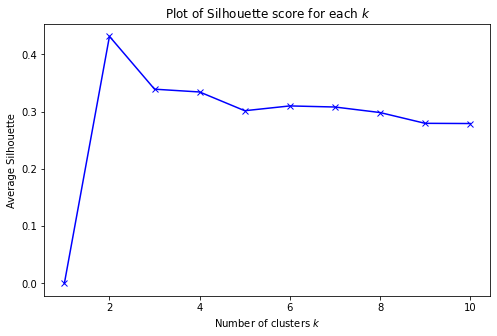

In [121]:
# V) Finding optimum number of clusters
# 1)  Silhoutte score method - Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. 
# A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and 
# negative values indicate that those samples might have been assigned to the wrong cluster.

scores = [0]
for i in range(2,11):
    fitx = KMeans(n_clusters=i, init='random', n_init=5, random_state=109).fit(X_scaled)
    score = silhouette_score(X_scaled, fitx.labels_)
    print(f'Silhouette Score(): {silhouette_score(X_scaled, fitx.labels_)}')
    scores.append(score)
    
plt.figure(figsize=(8,5))
plt.plot(range(1,11), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('Plot of Silhouette score for each $k$ ')
plt.show()


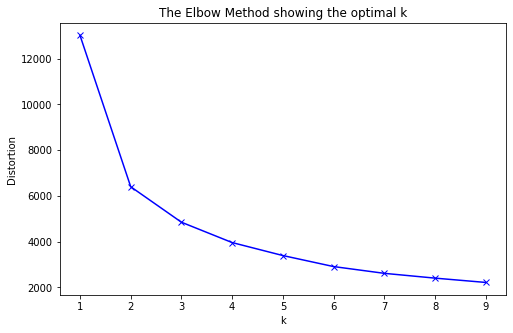

In [120]:
# 2) Elbow Method

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_scaled)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# As you can see from the plot, score k=3 is when it starts decreasing in a linear fashion.

Text(0, 0.5, 'amount_log')

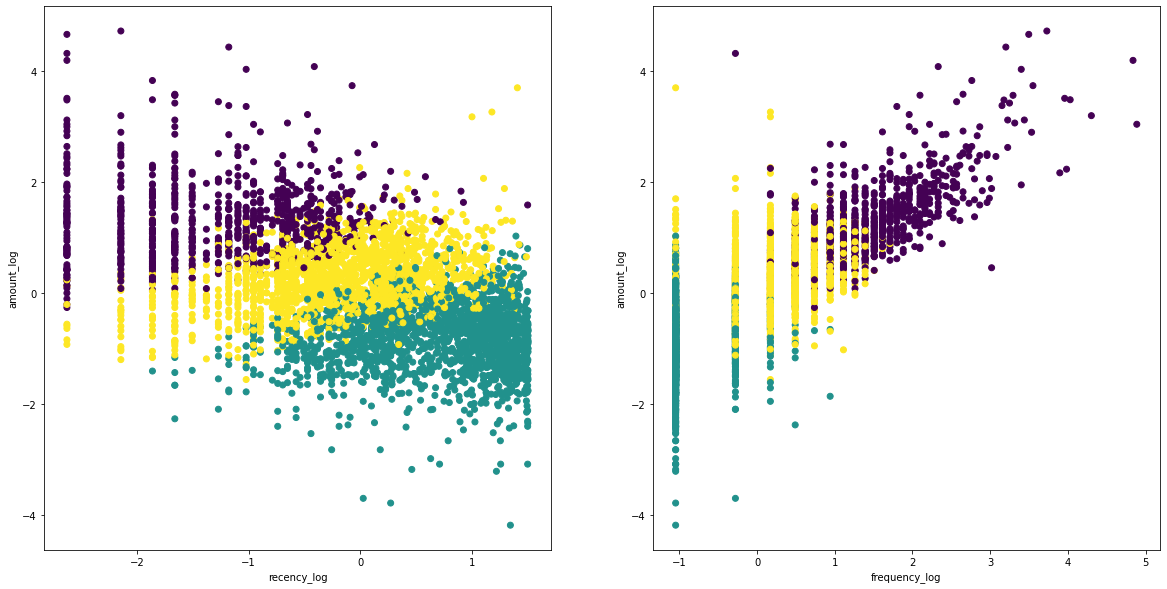

In [145]:
# VI) K-means

k2 = KMeans(n_clusters=3, init='random', n_init=5, random_state=109)
model = k2.fit(X_scaled)
labels = model.labels_

# Visualize it:
fig = plt.figure(figsize=(20,10))

#amount vs recency
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float)) 
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])

#amount vs frequency
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])


In [111]:
#From this we can infer that 1) customers who recently bought items at the shop tend to spend more money.
# 2) Customers who buy items more frequently tend to spend more money.